# ARIMA Modeling

### Learning Objectives
This is meant as a quick checkout to compare the results of our complex LSTM NLP model with that of a simplistic SARIMAX model
We will:
- Conduct and interpret an augmented Dickey-Fuller test for stationarity on several datasets including CPI, Bonds and 3mnth rates.  We will also use CPI as en exogenous variable for the prediction of the other two rates models.
- Construct integrated autoregressive moving average (ARIMA) models for rates .
- Fit and tune a SARIMAX model.

In [54]:
# !pip install scipy statsmodels --upgrade

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

In [93]:
# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [132]:
# Read in data.
bonds = pd.read_parquet('../data/bonds.parquet')
short_rates = pd.read_parquet('../data/three_month_rates.parquet')
cpi = pd.read_parquet('../data/cpi.parquet')
commodities = pd.read_parquet('../data/commodities.parquet')
#data = data.drop(data.index[:2])

In [133]:
#authors note. these dataframes will be used for exogonous analysis only when training sarimamax models

commodities_diff = commodities.pct_change()
bonds_diff = bonds.pct_change()



In [162]:
prices = commodities_diff.merge(cpi.shift(), left_index=True, right_index=True)

In [134]:
common_indexes = commodities.index.intersection(cpi.index)

# Select rows from commodities dataframe that exist in bonds dataframe
commodities = commodities.loc[common_indexes]
short_rates = short_rates.loc[common_indexes]
cpi = cpi.loc[common_indexes]
bonds = bonds.loc[common_indexes]
commodities_diff = commodities_diff.loc[common_indexes]
bonds_diff = bonds_diff.loc[common_indexes]
cpi_diff = cpi_diff.loc[common_indexes] 

In [175]:
def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    # Set figure size to be (18, 9).
    plt.figure(figsize=(7,3))
    # Iterate through each column name.
    for col in cols:    
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col], label=col)  # Add label parameter to your plot
        
    # Generate title and labels.
    plt.title(title, fontsize=16)
    plt.xlabel(xlab, fontsize=10)
    plt.ylabel(ylab, fontsize=10)
    
    # Create the legend and place it in the upper right corner.
    plt.legend(loc='upper right')
    
    # Enlarge tick marks.
    plt.yticks(fontsize=10)
    plt.xticks(df.index[0::steps], fontsize=8)

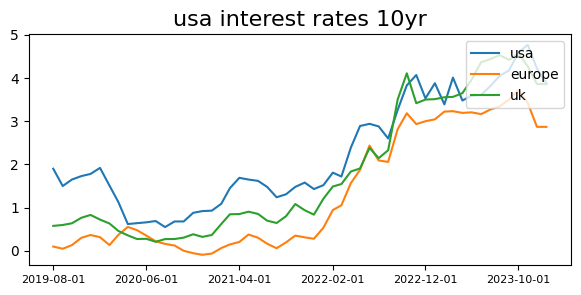

In [176]:
# Generate a time plot of our bus ridership data.
plot_series(data, ['usa', 'europe', 'uk'], title = 'usa interest rates 10yr', steps=10)

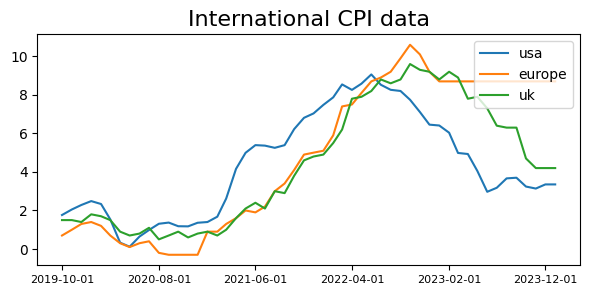

In [177]:
plot_series(cpi, ['usa', 'europe', 'uk'], title = 'International CPI data', steps=10)

In [167]:
commodities.columns

Index(['gold', 'copper', 'crude oil', 'soy'], dtype='object')

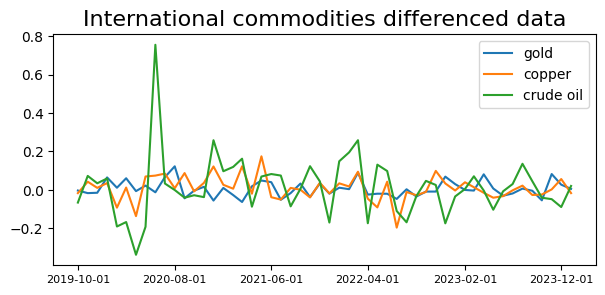

In [178]:
#cols_dict = {"GC": "gold", "HG": "copper", "CL": "crude oil", "ZS": "soy"}
plot_series(commodities_diff, ['gold', 'copper', 'crude oil'], title = 'International commodities differenced data', steps=10)

#### Checking for Stationarity: the Augmented Dickey-Fuller Test

In [110]:
# Code written by Joseph Nelson.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [118]:
# Run ADF test on (differenced!) data.
# japan and brazil need second order differences to be stationary
adf_df_bonds = pd.DataFrame()

for country in bonds.columns.tolist():
    # Assuming 'interpret_dftest' returns a dictionary of test statistics
    adf_results = interpret_dftest(adfuller(bonds[country].diff().dropna()))
    
    # Convert the results to a DataFrame and append it to 'adf_df'
    adf_df[country] = adf_results
adf_df_bonds

,usa,canada,europe,uk,australia,brazil,india,switzerland,japan,south korea
Test Statistic,-4.540001,-4.622160,-5.404654,-5.865958e+00,-5.481182,-2.286662,-7.119090e+00,-8.881716e+00,-1.844126,-5.859925e+00
p-value,0.000166,0.000118,0.000003,3.325226e-07,0.000002,0.176306,3.763250e-10,1.312516e-14,0.358785,3.429484e-07


In [179]:
# Run ADF test on CPI data.
# India and brazil need second order differences to be stationary
adf_df_cpi = pd.DataFrame()

for country in cpi.columns.tolist():
    # Assuming 'interpret_dftest' returns a dictionary of test statistics
    adf_results = interpret_dftest(adfuller(cpi[country].diff().dropna()))
    
    # Convert the results to a DataFrame and append it to 'adf_df'
    adf_df_cpi[country] = adf_results
adf_df_cpi

,usa,canada,europe,uk,australia,brazil,india,switzerland,japan,south korea
Test Statistic,-3.126097,-4.714633,-4.388798,-2.650703,-7.003209e+00,-2.324225,-2.494568,-3.823252,-6.872975e+00,-5.132303
p-value,0.024681,0.000079,0.000311,0.082964,7.232207e-10,0.164274,0.116802,0.002678,1.499176e-09,0.000012


In [180]:
# Run ADF test on CPI data.
# India and brazil need second order differences to be stationary
adf_df_commodities = pd.DataFrame()

for country in commodities.columns.tolist():
    # Assuming 'interpret_dftest' returns a dictionary of test statistics
    adf_results = interpret_dftest(adfuller(commodities[country].pct_change().dropna()))
    
    # Convert the results to a DataFrame and append it to 'adf_df'
    adf_df_commodities[country] = adf_results
adf_df_commodities

,gold,copper,crude oil,soy
Test Statistic,-7.236547e+00,-7.506578e+00,-6.559944e+00,-5.757972e+00
p-value,1.932855e-10,4.119483e-11,8.430381e-09,5.760285e-07


<Figure size 300x200 with 0 Axes>

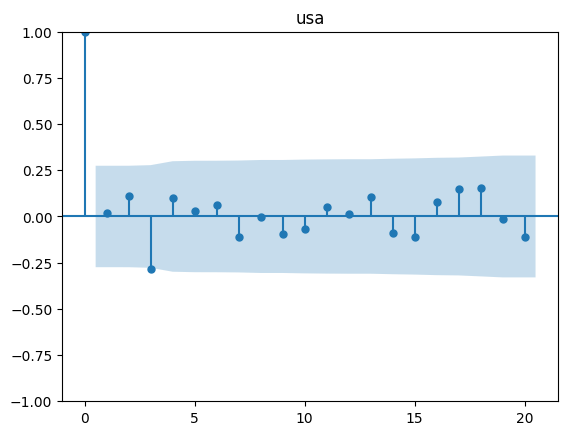

<Figure size 300x200 with 0 Axes>

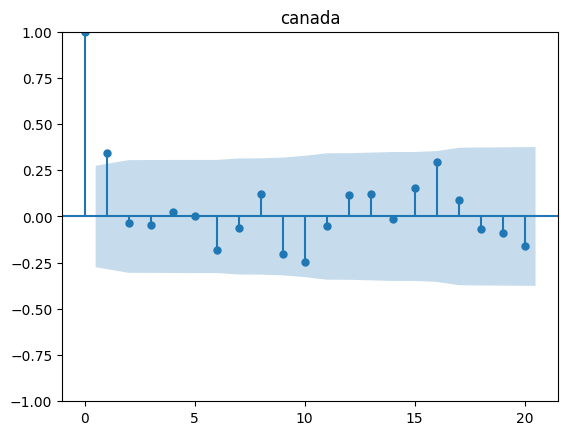

<Figure size 300x200 with 0 Axes>

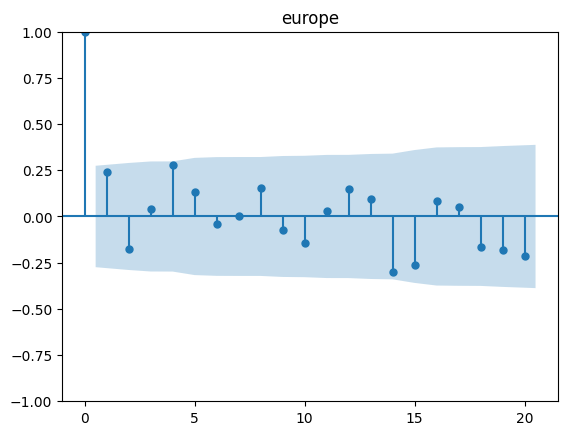

<Figure size 300x200 with 0 Axes>

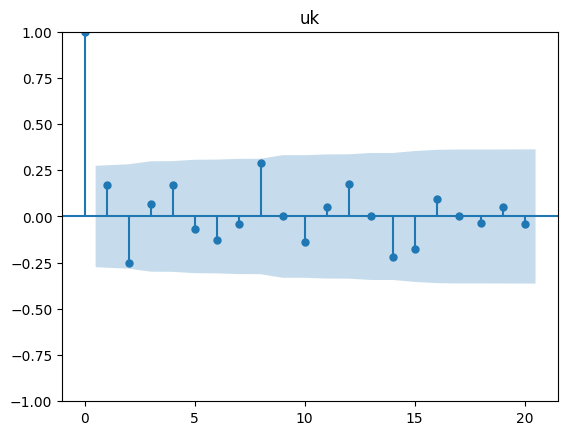

<Figure size 300x200 with 0 Axes>

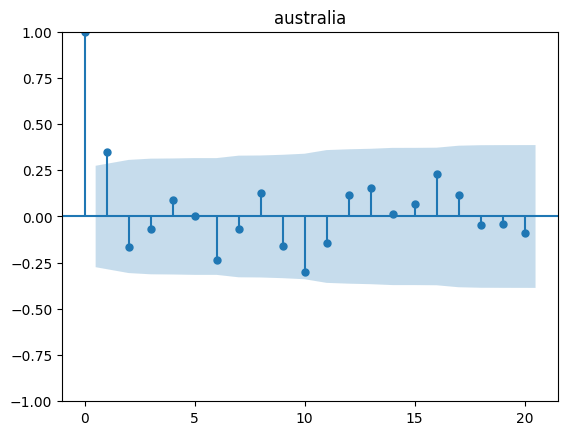

<Figure size 300x200 with 0 Axes>

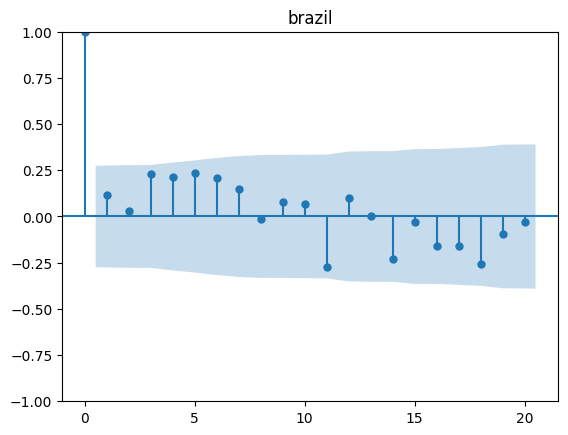

<Figure size 300x200 with 0 Axes>

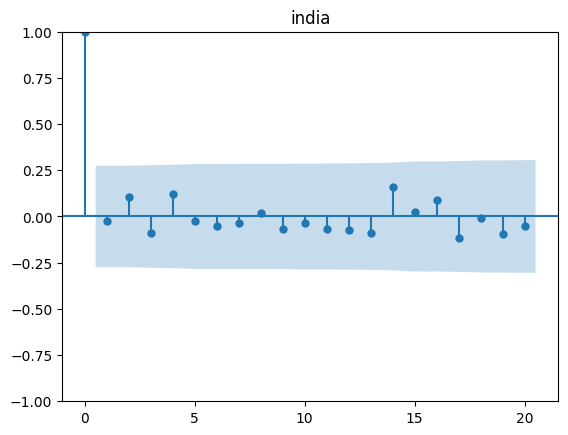

<Figure size 300x200 with 0 Axes>

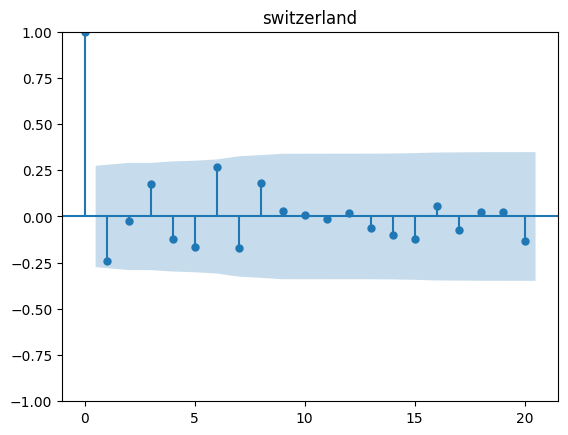

<Figure size 300x200 with 0 Axes>

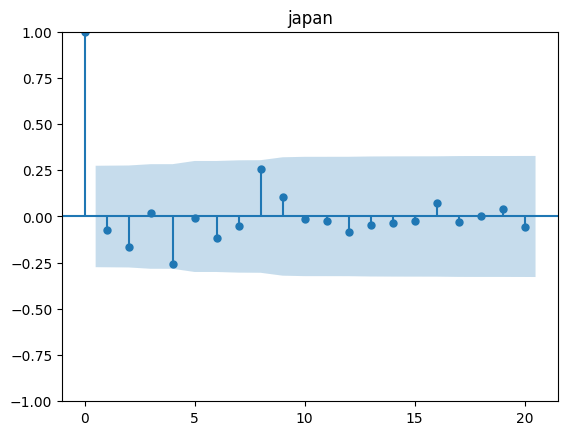

<Figure size 300x200 with 0 Axes>

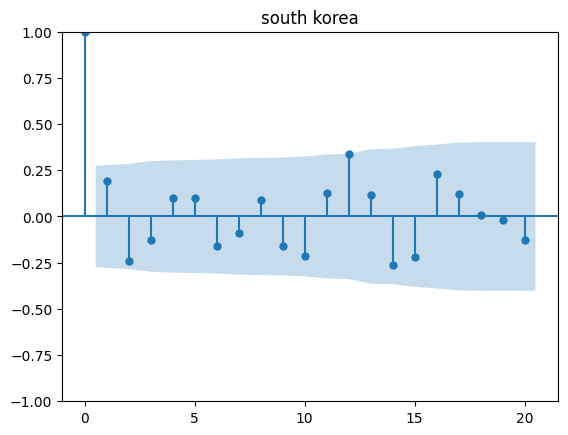

In [126]:
# Generate plot.
for country in bonds.columns.tolist():
	plt.figure(figsize=(3, 2)) 
	plot_acf(bonds[country].diff().dropna(), lags=20)
	plt.title(f'{country} acf plot');

<Figure size 300x200 with 0 Axes>

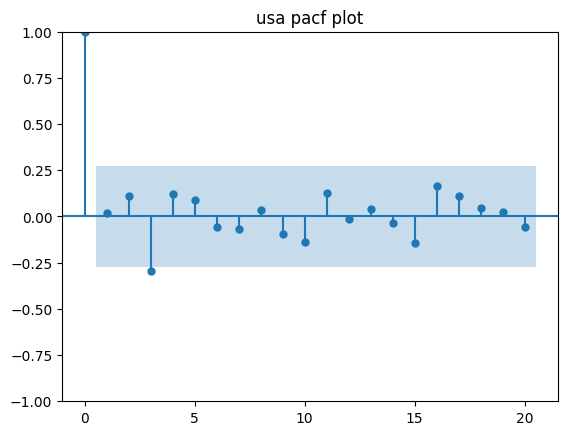

<Figure size 300x200 with 0 Axes>

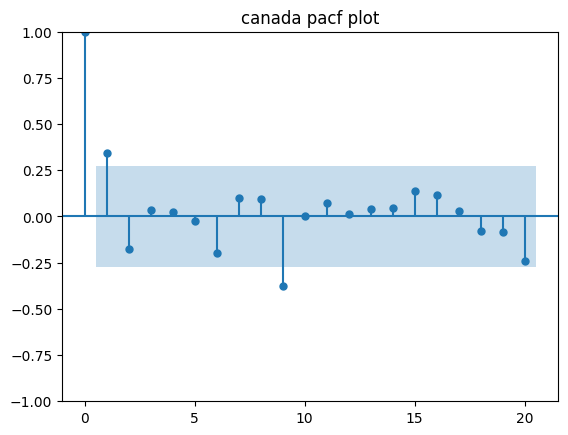

<Figure size 300x200 with 0 Axes>

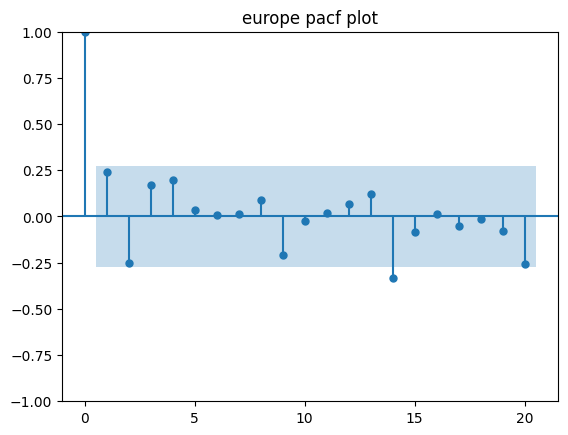

<Figure size 300x200 with 0 Axes>

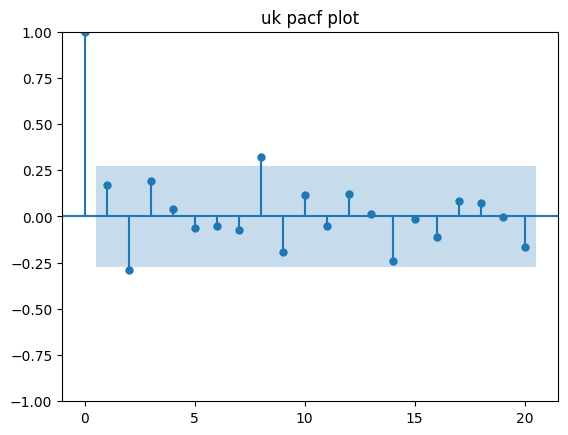

<Figure size 300x200 with 0 Axes>

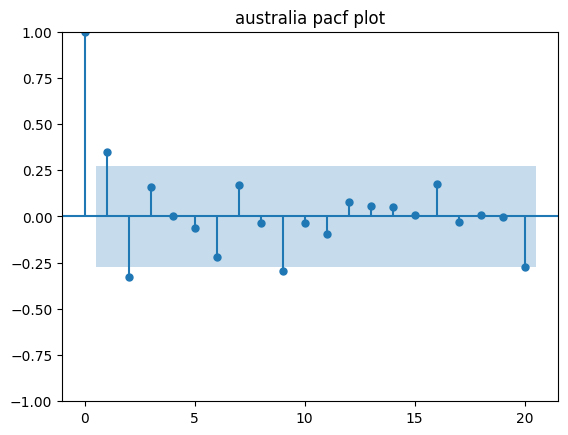

<Figure size 300x200 with 0 Axes>

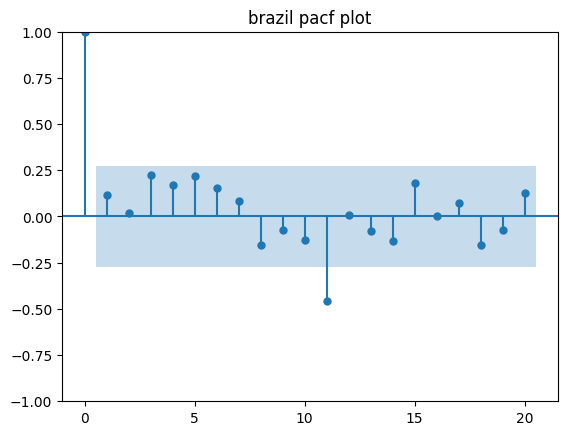

<Figure size 300x200 with 0 Axes>

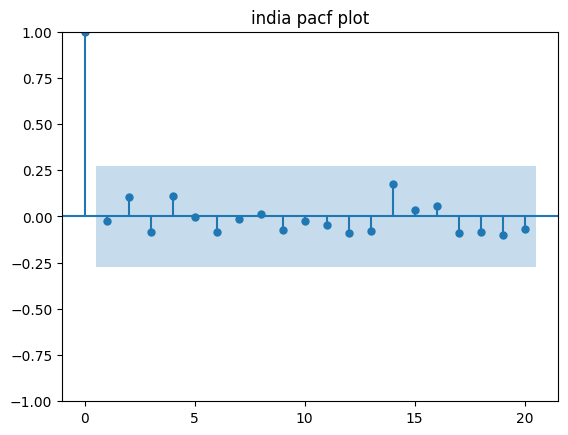

<Figure size 300x200 with 0 Axes>

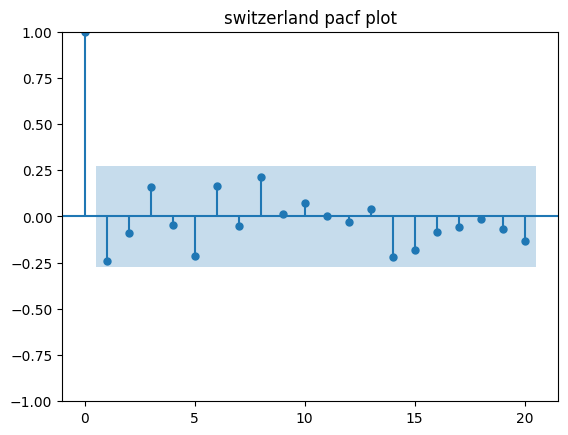

<Figure size 300x200 with 0 Axes>

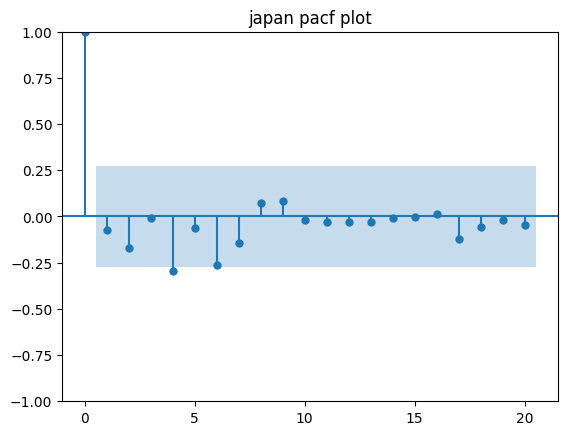

<Figure size 300x200 with 0 Axes>

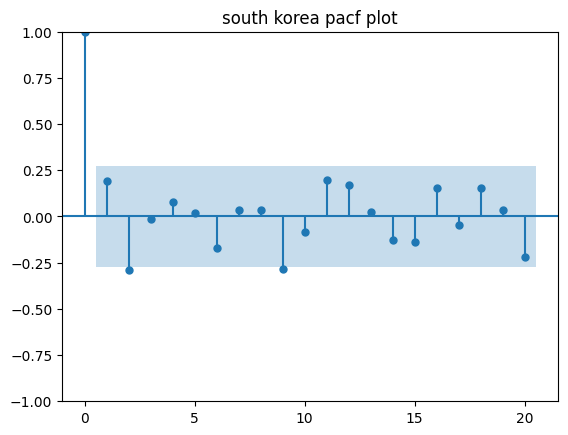

In [129]:
# Generate plot.
# Generate plot.
for country in bonds.columns.tolist():
	plt.figure(figsize=(3, 2)) 
	plot_pacf(bonds[country].diff().dropna(), lags=20)
	plt.title(f'{country} pacf plot');


<details><summary>How would you interpret the partial autocorrelation plot here?</summary>

### Interpret the partial autocorrelation plot.
1. The partial autocorrelation plot above shows that observations are highly correlated with one another. 
2. **However, the partial autocorrelation plot checks for the correlation between observations, conditioning on all lower-lag autocorrelations.** (That is, the partial autocorrelation between $Y_t$ and $Y_{t-2}$ is the correlation between $Y_t$ and $Y_{t-2}$ that has already taken into account the autocorrelation between $Y_t$ and $Y_{t-1}$.)
3. The blue band indicates the 95% confidence interval for these correlations.
    - Observations inside the blue band mean that there is no significant correlations between $Y_t$ and $Y_{t-k}$ for lag $k$, **accounting for all lower-order lags**.
    - Observations outside the blue band mean that there **is** a significant correlation between $Y_t$ and $Y_{t-k}$ for lag $k$, **accounting for all lower-order lags**.
</details>

In [192]:
prices = prices.fillna(method='ffill').fillna(method='bfill')

C:\Users\USER\AppData\Local\Temp\ipykernel_18268\4215695368.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prices = prices.fillna(method='ffill').fillna(method='bfill')


In [193]:
# Create train-test split.
X_10yr_train, X_10yr_test, y_10yr_train, y_10yr_test = train_test_split(prices,
                                                    bonds['usa'],
                                                    test_size = 0.3,
                                                    shuffle = False) # Shuffle = False is IMPORTANT!

# Create train-test split.
X_cpi_train, X_cpi_test, y_cpi_train, y_cpi_test = train_test_split(commodities_diff,
                                                    cpi['usa'],
                                                    test_size = 0.3,
                                                    shuffle = False) # Shuffle = False is IMPORTANT!

### Fit an ARIMA model.


In [68]:
# Import ARIMA model.
from statsmodels.tsa.arima.model import ARIMA

In [144]:
# Instantiate model.

# Remember that, in statsmodels, we pass our data 
# in when we instantiate the model!
#this model was selected after 
model = ARIMA(endog=y_10yr_train.astype(float).dropna(),order=(3,1,3))


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [145]:
# Fit model.
arima_3_1_3 = model.fit()

c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [146]:
y_test.head()

2022-10-01    3.83
2022-11-01    4.07
2022-12-01    3.53
2023-01-01    3.88
2023-02-01    3.39
Name: usa, dtype: float64

In [147]:
# Generate predictions.
preds = arima_3_1_3.predict(start = datetime(2022, 10, 1), end = datetime(2024, 1, 1))

<details><summary>What do these predicted values represent?</summary>

- These predicted values represent $Y''_t$, which is the second-order differenced bus ridership data.
- The first observation represents the "change of the change" in bus ridership in January 1973.
- The second observation represents the "change of the change" in bus ridership in February 1973.
- And so on.
</details>

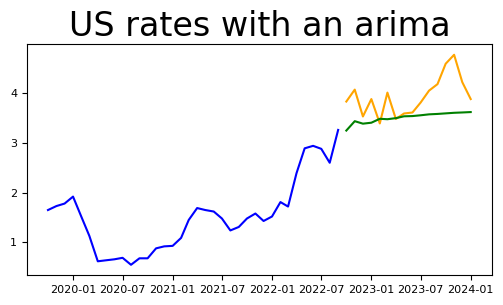

In [155]:
# Plot data.
# Set figure size.
plt.figure(figsize=(6,3))
# Plot training data.
plt.plot(y_10yr_train.index, pd.DataFrame(y_10yr_train), color = 'blue')
# Plot testing data.
plt.plot(y_10yr_test.index, pd.DataFrame(y_10yr_test), color = 'orange')
# Plot predicted test values.
plt.plot(y_10yr_test.index, preds, color = 'green')
# Set label.
plt.title(label = 'US rates with an arima', fontsize=24)
# Resize tick marks.
plt.xticks(fontsize=8)
plt.yticks(fontsize=8);

In [156]:
# Evaluate these predictions using MSE.
from  sklearn.metrics import mean_squared_error

print(mean_squared_error(y_10yr_test, preds))

0.296101245048759


In [157]:
arima_3_1_3.aic

11.353266226407955

## Seasonal Model

We can think of seasonality as a repeating pattern (like a cycle) that occurs over time.

In [ ]:
# Import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


13.365149046908211


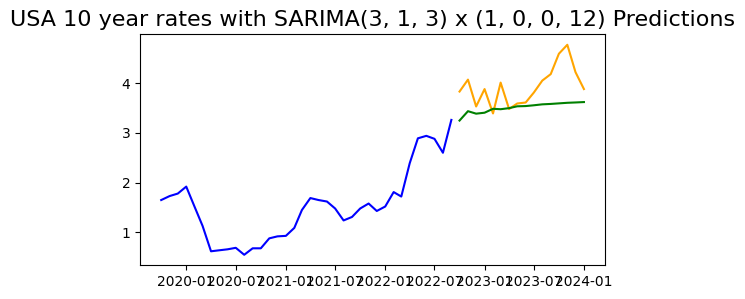

In [189]:
# Fit a SARIMA(0, 2, 1) x (1, 0, 0, 12) model.
sarima = SARIMAX(endog=y_10yr_train.astype(float),
                order = (3, 1, 3), seasonal_order=(1, 0, 0, 12)) #1 repeat seasonality repeated every 12 months

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(start = datetime(2022, 10, 1), end = datetime(2024, 1, 1))

# Evaluate predictions.
print(model.aic)

# Plot data.
plt.figure(figsize=(6,3))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'USA 10 year rates with SARIMA(3, 1, 3) x (1, 0, 0, 12) Predictions', fontsize=16)
plt.show();

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3.2799774584053765


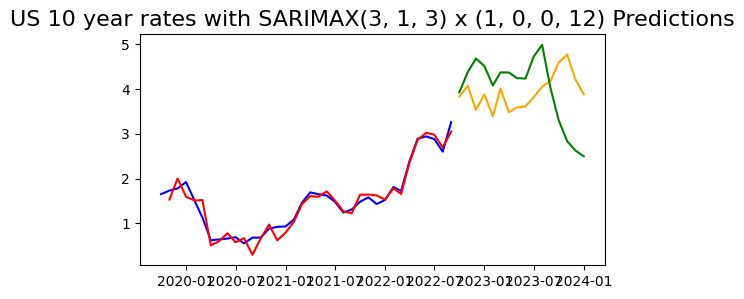

In [196]:
# Fit a SARIMA(0, 2, 1) x (0, 0, 1, 12) model.
sarima = SARIMAX(endog=y_10yr_train.astype(float),
                order = (3, 1, 2), seasonal_order=(1, 0, 0, 12),
                exog = X_10yr_train.astype(float))


# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
overlap = model.predict(start = datetime(2019, 11, 1), end = datetime(2022, 9, 1),
                     exog = X_10yr_train.astype(float))
preds = model.predict(start = datetime(2022, 10, 1), end = datetime(2024, 1, 1),
                     exog = X_10yr_test.astype(float))

# Evaluate predictions.
print(model.aic)

# Plot data.
plt.figure(figsize=(6,3))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds, color = 'green')
plt.plot(overlap, color = 'red')
plt.title(label = 'US 10 year rates with SARIMAX(3, 1, 3) x (1, 0, 0, 12) Predictions', fontsize=16)
plt.show();

### Manual GridSearch


In [204]:
start = X_10yr_test.index[0]
stop = X_10yr_test.index[-1]
y_start = y_10yr_test.index[0]
y_stop = y_cpi_test.index[-1]

print(y_start, y_stop)

2022-10-01 00:00:00 2024-01-01 00:00:00


In [ ]:
# Starting MSE and (P, D, Q, S).
best_mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0
final_S = 0

for P in range(3):
    for Q in range(3):
        for D in range(2):
            for S in range(0,13,4):
                try:
                    print(f'Attempting to fit SARIMAX(0,2,1)x({P},{D},{Q},{S})')
                    # Instantiate SARIMAX model.
                    sarimax = SARIMAX(endog = y_10yr_train,
                                     order = (3, 1, 3),              # (p, d, q)
                                     seasonal_order = (P, D, Q, S),  # (P, D, Q, S)
                                     exog = X_10yr_train) 
 
                    # Fit SARIMAX model.
                    model = sarimax.fit()

                    # Generate predictions based on test set.
                    preds = model.predict(start=start,
                                          end=stop,
                                          exog=X_10yr_test)

                    # Evaluate predictions.
                    print(f'The MSE for (0, 1, 1)x({P},{D},{Q},{S}) is: {mean_squared_error(y_10yr_test, preds)}')

                    # Save for final report.
                    if best_mse > mean_squared_error(y_10yr_test, preds):
                        best_mse = mean_squared_error(y_10yr_test, preds)
                        final_P = P
                        final_D = D
                        final_Q = Q
                        final_S = S

                except:
                    pass

print(f'Our model that minimizes MSE on the testing data is the SARIMAX(3, 1, 3)x({final_P},{final_D},{final_Q},{final_S}).')
print(f'This model has an MSE of {best_mse}.')

In [ ]:
# Define the combinations of ARIMA parameters you want to try
arima_params = [(p, 1, q) for p in range(4) for q in range(4)]

# Fit the models
models = fit_sarimax_models(y_10yr_train, arima_params)


In [ ]:
def fit_sarimax_models(y_train, y_test, X_train, X_test, arima_params, seasonal_order=(1, 0, 0, 12)):
    """
    Fit SARIMAX models for each combination of ARIMA parameters.

    Parameters:
    - y_train: The endogenous variable
    - arima_params: A list of tuples, where each tuple represents a combination of (p, d, q) parameters for the ARIMA part
    - seasonal_order: A tuple representing the (P, D, Q, S) parameters for the seasonal part of the model

    Returns:
    - A dictionary where the keys are the ARIMA parameters and the values are the fitted models
    """
    models = {}

    for params in arima_params:
        try:
            model = SARIMAX(endog=y_train.astype(float).dropna(),
                            order=params,
                            seasonal_order=seasonal_order,
                            exog = X_train)
            results = model.fit()
            preds = model.predict(start=start, end=stop, exog=X_test)

            # Evaluate predictions.
            print(f'The MSE for (0, 1, 1)x({P},{D},{Q},{S}) is: {mean_squared_error(y_test, preds)}')

            # Save for final report.
            if best_mse > mean_squared_error(y_10yr_test, preds):
                best_mse = mean_squared_error(y_10yr_test, preds)
                final_P = P
                final_D = D
                final_Q = Q
                final_S = S
            models[params] = results
        except:
            continue

    return models

c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


782.2085664888484


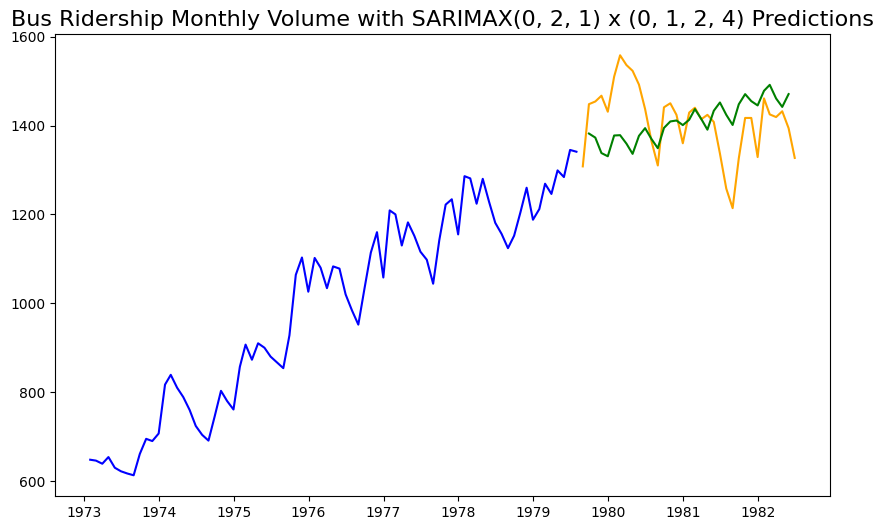

In [ ]:
# Fit a SARIMA(0, 2, 1) x (0, 1, 2, 4) model.
sarima = SARIMAX(endog = y_10yr_train,
                                     order = (3, 1, 3),              # (p, d, q)
                                     seasonal_order = (0, 1, 2, 4),  # (P, D, Q, S)
                                     exog = X_10yr_train) 

# Fit SARIMA model.
model = sarima.fit()

print(model.aic)

# Generate predictions based on test set.
preds = model.predict(start = datetime(1979, 9, 30),
                     end = datetime(1982, 5, 31),
                     exog = X_10yr_test)

# Evaluate predictions.

# Plot data.
plt.figure(figsize=(10,6))
plt.plot(y_train, color = 'blue')
plt.plot(y_test, color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Bus Ridership Monthly Volume with SARIMAX(0, 2, 1) x (0, 1, 2, 4) Predictions', fontsize=16)
plt.show();

## Takeaways

While we GridSearched over a range of values for the parameters in our SARIMAX model, our model here doesn't look *that* great. Why might that be?

- Looking at the original time plot of our data, when we split our data into the training and the testing sets, it appears that our testing data looks a bit different from our training data. (Obviously this will affect our model, since we only fit on our testing set!) This isn't something we often have much control over.
- There are many, many factors that affect the number of people who take the bus in Portland.
    - The number of bus passengers in the past.
    - Precipitation.
    - Temperature.
    - The population of Portland.
    - The price of cars. (e.g. if cars got cheaper around 1980, perhaps more people began taking cars instead of buses.)
    - Other alternative modes of transportation. (e.g. are there other forms of public transportation, like a train/subway that may affect the number of passengers?)
- **Forecasting time series is exceptionally difficult to do well!** We're using the past to predict the future, and there aren't guarantees that the future is necessarily going to be reflective of the past.